In [10]:
import matplotlib.pyplot as plt
from keras.models import Model, Input
from keras.layers import Dropout,Dense
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,\
    precision_score,recall_score,f1_score
import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import norm
import itertools
from keras.callbacks import ModelCheckpoint
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from imblearn.over_sampling import SMOTE
from scipy.stats import entropy

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report

In [11]:
df = pd.read_csv('../cisco/cisco.csv', skiprows=0)
df.drop(["idx_col"], axis=1, inplace=True)
class_names = df.label.unique()
df.sample(10)

,Encryption,Encryption_sBestEffort,ListenPort,ListenPort_sBestEffort,DefaultCall_Protocol,DefaultCall_Protocol_s2,DefaultTransport,DefaultTransport_s2,Ice_DefaultCandidate,MTU,MTU_s2,DefaultCall_Rate,DefaultCall_Rate_s2,MaxTransmitCallRate,MaxReceiveCallRate,MaxTransmitCallRate_s2,MaxReceiveCallRate_s2,label
1547,2,2,1,0,3,2,2,1,0,752.0,1163.0,2025.0,3397.0,3712.0,495.0,3464.0,3405.0,1
3800,2,1,0,0,3,2,2,1,1,1085.0,1368.0,4695.0,1781.0,1404.0,201.0,2557.0,3660.0,1
3804,2,2,1,0,0,2,2,1,2,1012.0,689.0,2266.0,2241.0,2572.0,1599.0,3060.0,1223.0,0
1709,1,0,1,1,0,1,0,1,2,797.0,933.0,4952.0,2835.0,2567.0,2185.0,2319.0,4164.0,0
8783,2,0,1,1,0,0,2,0,1,684.0,963.0,3978.0,2068.0,4323.0,4970.0,4680.0,1757.0,0
9880,2,2,0,0,3,2,2,1,1,987.0,1055.0,4012.0,3197.0,810.0,2985.0,4469.0,2344.0,1
10667,2,1,1,0,3,3,2,0,2,1019.0,1174.0,3390.0,5954.0,3973.0,4735.0,1042.0,5578.0,1
7807,2,1,0,0,0,2,2,1,0,986.0,1184.0,3616.0,626.0,4883.0,3202.0,3238.0,958.0,1
1673,0,0,1,1,0,2,1,3,0,738.0,1132.0,3746.0,675.0,1010.0,1610.0,1651.0,5870.0,0
7410,0,1,1,0,1,0,2,0,1,919.0,1150.0,3855.0,4515.0,5979.0,5241.0,2448.0,2880.0,1


In [12]:
y = df.label.values
y = LabelBinarizer().fit_transform(y)
y = np.hstack((y, 1 - y))
df.drop(["label"], axis=1, inplace=True)

X = df.values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33)

In [13]:
y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [14]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)

def shannon_entropy(vals):
    return -1*np.sum([ val*np.log2(val+0.000000000001) for val in vals])

def get_model(mc=False, act="relu", dropout_size=0.3, num_of_class=2, input_size=2):
    inp = Input(input_size, name='main_input')
    x = Dense(100, activation=act,name='Layer-1')(inp)
    if mc:
        x = get_dropout(x, p=dropout_size, mc=mc)
    x = Dense(200, activation=act,name='Layer-2')(x)
    if mc:
        x = get_dropout(x, p=dropout_size, mc=mc)
    x = Dense(100, activation=act,name='Layer-3')(x)
    if mc:
        x = get_dropout(x, p=dropout_size, mc=mc)
    out = Dense(num_of_class, activation='softmax',name='Output-layer')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy",
                  optimizer="rmsprop",
                  metrics=['accuracy'])

    return model

In [17]:
epoch_size = 200
batch_size = 10000

mcp_save = ModelCheckpoint('video_model.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

pred_model_mc = get_model(mc=True, 
                          num_of_class=2, 
                          dropout_size=0.02,
                          input_size=X.shape[1],
                          act="relu")

history_mc = pred_model_mc.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epoch_size,
              callbacks=[mcp_save],
              verbose=0,
              validation_data=(X_test, y_test))
pred_model_mc.load_weights('video_model.hdf5')

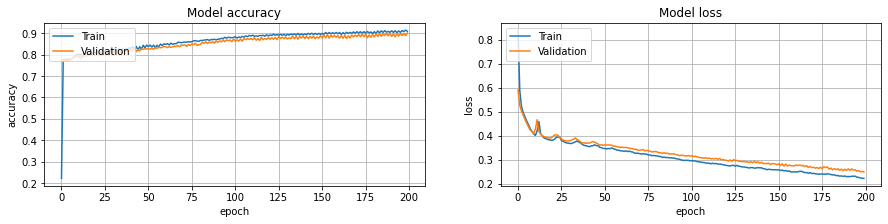

In [18]:
plots = ['accuracy','loss']
i = 0
fig = plt.figure(figsize=(15, 3))
for plot_type in plots:
    ax = fig.add_subplot(1, 2, i+1)
    ax.plot(history_mc.history[plot_type])
    ax.plot(history_mc.history['val_' + plot_type])
    ax.set_title('Model ' + plot_type)
    ax.set_ylabel(plot_type)
    ax.set_xlabel('epoch')
    ax.legend(['Train', 'Validation'], loc='upper left')
    ax.grid(True)
    i =+ 1
plt.show()

In [19]:
# Monte carlo predictions
mc_predictions = []
for i in tqdm.tqdm(range(200)):
    y_p = pred_model_mc.predict(X_test, batch_size=1000)
    mc_predictions.append(y_p)

max_means = []
preds = []
entropy_vals = []
std_vals = []
for idx in range(X_test.shape[0]):
    px = np.array([p[idx] for p in mc_predictions])
    #print(px.max(axis=1))
    preds.append(px.mean(axis=0).argmax())
    max_means.append(px.mean(axis=0).max())
    prob_dist = []
    for i, (prob, var) in enumerate(zip(px.mean(axis=0), px.std(axis=0))):
        prob_dist.append(prob)
    entropy_vals.append(shannon_entropy(prob_dist))
    #entropy_vals.append(entropy(prob_dist, base=2))
    std_vals.append(np.std(px.max(axis=1)))

unc_ent_idx = np.flip((np.array(entropy_vals)).argsort()[-3:])
unc_std_idx = np.flip((np.array(std_vals)).argsort()[0:3])

100%|██████████| 200/200 [00:07<00:00, 26.96it/s]


IndexError: index 2 is out of bounds for axis 1 with size 2

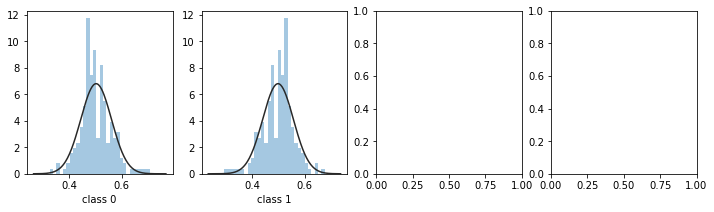

In [20]:
for idx_iter in range(3):
    idx = unc_ent_idx[idx_iter]
    p0 = np.array([p[idx] for p in mc_predictions])
    prob_txt = []
    prob_txt.append("True: {}".format(y_test[idx].argmax()))
    prob_txt.append(", Pred: {}".format(p0.mean(axis=0).argmax()))

    prob_dist = []

    for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
        prob_txt.append(", Class {} prob: {:2.2f}\%".format(i, prob*100))
        prob_dist.append(prob)
    prob_txt.append(", Ent: {:.2f}".format(shannon_entropy(prob_dist)))

    prob_txt = " ".join(prob_txt).strip()
    fig, axes = plt.subplots(1, 4, figsize=(12,3))

    for i, ax in enumerate(fig.get_axes()):
        sns.distplot( p0[:,i],ax=ax, bins=30, fit=norm, kde=False)
        ax.set_xlabel(f"class {i}")

    plt.title(prob_txt)
    fig.tight_layout()
    
    plt.show()

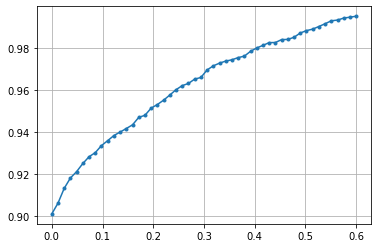

In [21]:
df_results = pd.DataFrame(data = X_test,
                  columns=['f' + str(i) for i in range(X_test.shape[1])])
df_results['y'] = y_test.argmax(axis=1)
df_results['y_hat'] = preds
df_results['unc_entropy'] = entropy_vals
df_results['unc_std'] = std_vals

discarded_ratio_list = np.linspace(0,0.6,num=50)

df_results.sort_values(by=['unc_entropy'],ascending=True,inplace=True)

acc_list = []
for discarded_ratio in discarded_ratio_list:
    tmp_df = df_results.head(np.int(df_results.shape[0] * (1-discarded_ratio)))
    y = tmp_df.y.values
    y_hat = tmp_df.y_hat.values
    acc_list.append(accuracy_score(y,y_hat))
plt.plot(discarded_ratio_list,acc_list, '-', marker = '.')
plt.grid()
plt.show()

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1121
           1       0.70      0.44      0.54       560

    accuracy                           0.75      1681
   macro avg       0.73      0.67      0.69      1681
weighted avg       0.74      0.75      0.73      1681



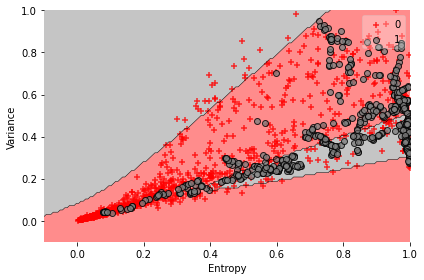

In [24]:
oversample = SMOTE(sampling_strategy=0.5)

X_unc = np.stack((entropy_vals,std_vals),axis=1)
scaler = MinMaxScaler()
X_unc = scaler.fit_transform(X_unc)

mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
wrong_labels = np.abs(y_test.argmax(axis=1) - mc_ensemble_pred)
wrong_labels[np.where(wrong_labels > 0)] = 1

X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_unc, wrong_labels, 
                                                    test_size=0.7)

X_w_train, y_w_train = oversample.fit_resample(X_w_train, y_w_train)

clf = SVC(gamma=1000,kernel='poly',C=1000,tol=1e-14, max_iter=1e8)
clf.fit(X_w_train, y_w_train)

y_pred = clf.predict(X_w_train)
cr = classification_report(y_w_train, y_pred)
print(cr)

ax = plot_decision_regions(X_w_train, y_w_train, clf=clf, legend=1,
                      markers='+o',hide_spines=True,colors='red,gray')
plt.xlim((-0.1,1.0))
plt.ylim((-0.1,1.0))
plt.xlabel('Entropy')
plt.ylabel('Variance')
plt.tight_layout()